<a href="https://colab.research.google.com/github/Lindaagstna/latihan11ML/blob/main/Latihan11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!pip install contextily

In [45]:
!pip install folium

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt

In [47]:
df =pd.read_csv('/content/drive/MyDrive/SEMESTER3/praktikum_ml/praktikum11/data/katalog_gempa.csv')
df.head()

tgl            ot   lat     lon  depth  mag  \
0  2008/11/01  21:02:43.058 -9.18  119.06     10  4.9   
1  2008/11/01  20:58:50.248 -6.55  129.64     10  4.6   
2  2008/11/01  17:43:12.941 -7.01  106.63    121  3.7   
3  2008/11/01  16:24:14.755 -3.30  127.85     10  3.2   
4  2008/11/01  16:20:37.327 -6.41  129.54     70  4.3   

                     remark  strike1  dip1  rake1  strike2  dip2  rake2  
0  Sumba Region - Indonesia      NaN   NaN    NaN      NaN   NaN    NaN  
1                 Banda Sea      NaN   NaN    NaN      NaN   NaN    NaN  
2          Java - Indonesia      NaN   NaN    NaN      NaN   NaN    NaN  
3         Seram - Indonesia      NaN   NaN    NaN      NaN   NaN    NaN  
4                 Banda Sea      NaN   NaN    NaN      NaN   NaN    NaN

In [48]:
df.isnull().sum()

tgl            0
ot             0
lat            0
lon            0
depth          0
mag            0
remark         0
strike1    90152
dip1       90152
rake1      90152
strike2    90152
dip2       90152
rake2      90152
dtype: int64

In [49]:
df_clean = df[['tgl', 'ot', 'lat', 'lon', 'depth', 'mag', 'remark']].copy()

In [50]:
df_clean.dropna(inplace=True)

In [51]:
df_clean.duplicated().sum()

np.int64(2735)

In [52]:
df_clean.drop_duplicates(inplace=True)

In [53]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90152 entries, 0 to 92886
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tgl     90152 non-null  object 
 1   ot      90152 non-null  object 
 2   lat     90152 non-null  float64
 3   lon     90152 non-null  float64
 4   depth   90152 non-null  int64  
 5   mag     90152 non-null  float64
 6   remark  90152 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 5.5+ MB


In [54]:
features = ['lat', 'lon', 'depth', 'mag']
df_cluster = df[features].copy()

In [55]:
m = folium.Map(location=[-2.5 , 118.0], zoom_start=5)
heatmap_data = df_cluster[['lat', 'lon']].values.tolist()

HeatMap(heatmap_data, radius=10).add_to(m)
m

In [56]:
np.random.seed(42)
long_peta = df['lon'] + np.random.uniform(low=-0.05, high=0.05, size=len(df))
lat_peta = df['lat'] + np.random.uniform(low=-0.05, high=0.05, size=len(df))

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(long_peta, lat_peta),
    crs='EPSG:4326')

gdf = gdf.to_crs(epsg=3857)

rata2_gempa = df.groupby('remark')['mag'].mean()
top_5 = rata2_gempa.sort_values(ascending=False).head(5)
bottom_5 = rata2_gempa.sort_values(ascending=True).head(5)

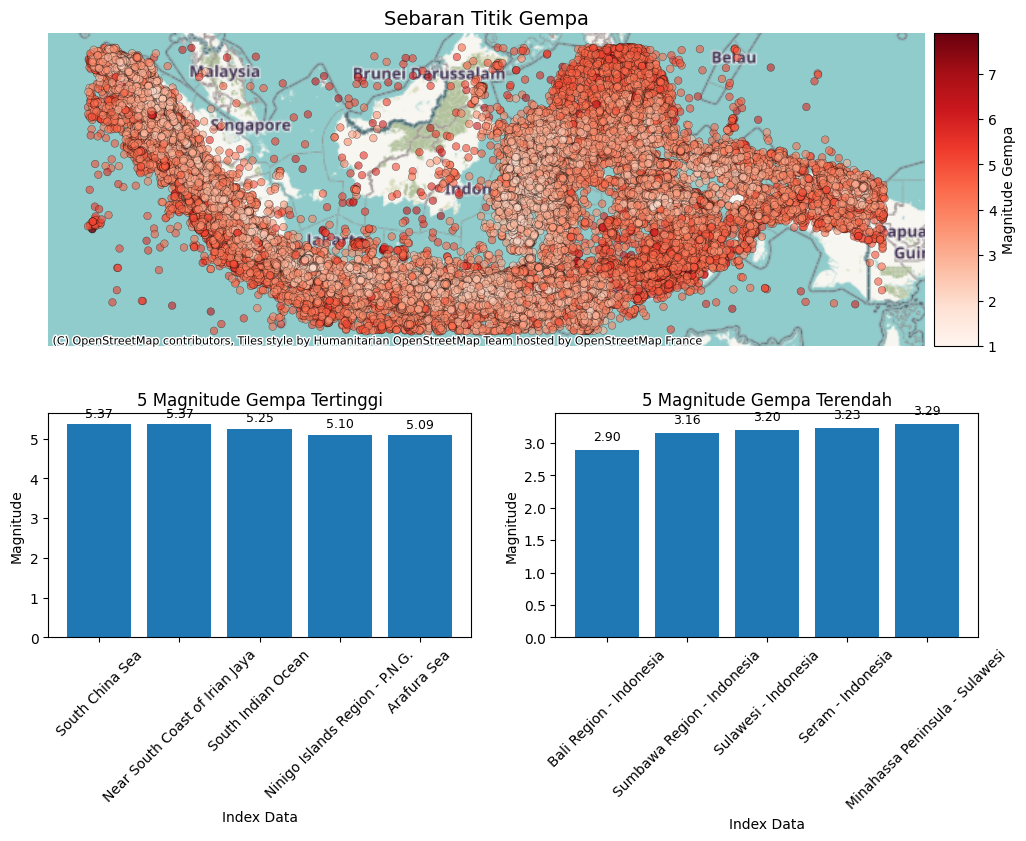

In [57]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2])

ax_map = plt.subplot(gs[0, :])
divider = make_axes_locatable(ax_map)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(
    ax=ax_map,
    column="mag",
    cmap="Reds",
    legend=True,
    legend_kwds={"label": "Magnitude Gempa", 'orientation': "vertical"},
    cax=cax,
    markersize=30,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.6
)

ctx.add_basemap(ax_map)
ax_map.set_title("Sebaran Titik Gempa", fontsize=14)
ax_map.set_axis_off()

ax_top = plt.subplot(gs[1, 0])
ax_top.bar(top_5.index.astype(str), top_5)
ax_top.set_xlabel("Index Data")
ax_top.set_title("5 Magnitude Gempa Tertinggi")
ax_top.set_ylabel("Magnitude")
ax_top.tick_params(axis='x', rotation=45)

# Add ax_bottom subplot and plot bottom_5 data
ax_bottom = plt.subplot(gs[1, 1]) # Define ax_bottom
ax_bottom.bar(bottom_5.index.astype(str), bottom_5) # Plot bottom_5
ax_bottom.set_xlabel("Index Data")
ax_bottom.set_title("5 Magnitude Gempa Terendah") # Title for bottom_5
ax_bottom.set_ylabel("Magnitude")
ax_bottom.tick_params(axis='x', rotation=45)

# Add text annotations for both top_5 and bottom_5 plots
for i, val in enumerate(top_5):
  ax_top.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

for i, val in enumerate(bottom_5):
  ax_bottom.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

In [59]:
from scipy.stats import shapiro

normalitas_data = df.drop(columns=['tgl','ot','remark','strike1', 'dip1',
       'rake1', 'strike2', 'dip2', 'rake2'])

normalitas_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     92887 non-null  float64
 1   lon     92887 non-null  float64
 2   depth   92887 non-null  int64  
 3   mag     92887 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 2.8 MB


In [60]:
stats, p = shapiro(normalitas_data)

print("Statik: ", stats)
print("P-value: ", p)

if p > 0.05:
  print("Data memiliki distribusi normal")
else:
  print("Data tidak memiliki distribusi normal")

Statik:  0.7040897083244015
P-value:  2.001104824274548e-174
Data tidak memiliki distribusi normal


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 371548.



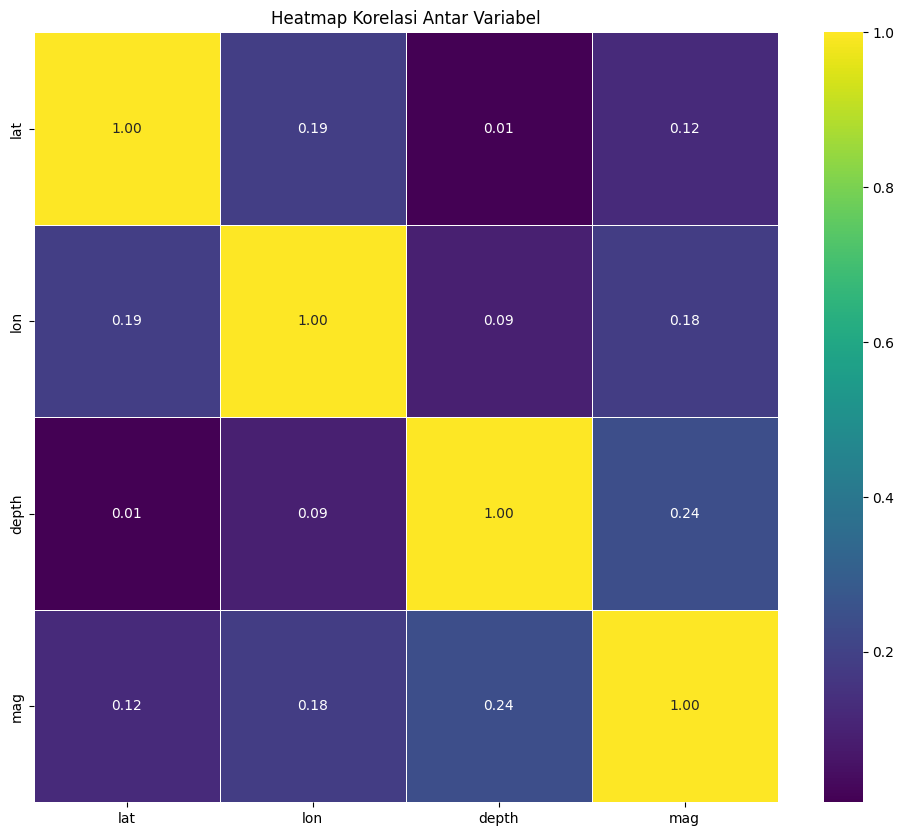

In [61]:
correlation_df = normalitas_data
correlation_matrix = correlation_df.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

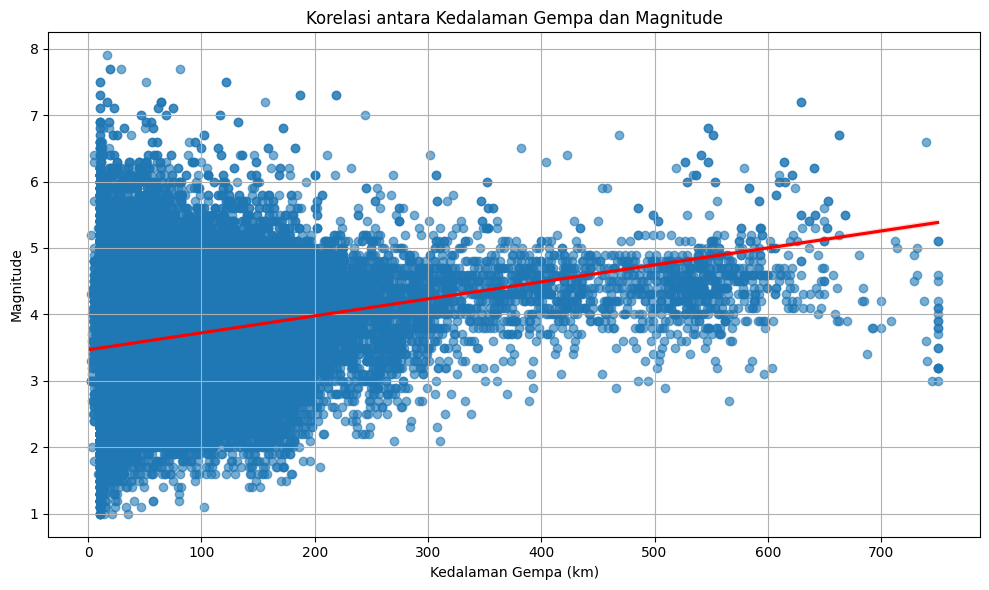

In [62]:
plt.figure(figsize=(10, 6))
sns.regplot( x="depth", y="mag", data=df, scatter_kws={'alpha': 0.6}, line_kws={"color": "red"})
plt.title("Korelasi antara Kedalaman Gempa dan Magnitude")
plt.xlabel("Kedalaman Gempa (km)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
normalisasi_df = df.drop(columns=['tgl','ot','remark','strike1', 'dip1',
       'rake1', 'strike2', 'dip2', 'rake2'])
normalisasi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     92887 non-null  float64
 1   lon     92887 non-null  float64
 2   depth   92887 non-null  int64  
 3   mag     92887 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 2.8 MB


In [64]:
normalisasi_df = df.drop(columns=['tgl','ot','remark','strike1', 'dip1',
       'rake1', 'strike2', 'dip2', 'rake2']) # Re-initialize as DataFrame
column_names = normalisasi_df.columns # Get column names before scaling
scaler = RobustScaler()
normalisasi_df = scaler.fit_transform(normalisasi_df)
normalisasi_df = pd.DataFrame(normalisasi_df, columns=column_names)
normalisasi_df.head()

lat       lon     depth       mag
0 -0.781308 -0.152950 -0.136364  1.166667
1 -0.453583  0.617626 -0.136364  0.916667
2 -0.510903 -1.058267  2.386364  0.166667
3 -0.048598  0.487254 -0.136364 -0.250000
4 -0.436137  0.610342  1.227273  0.666667

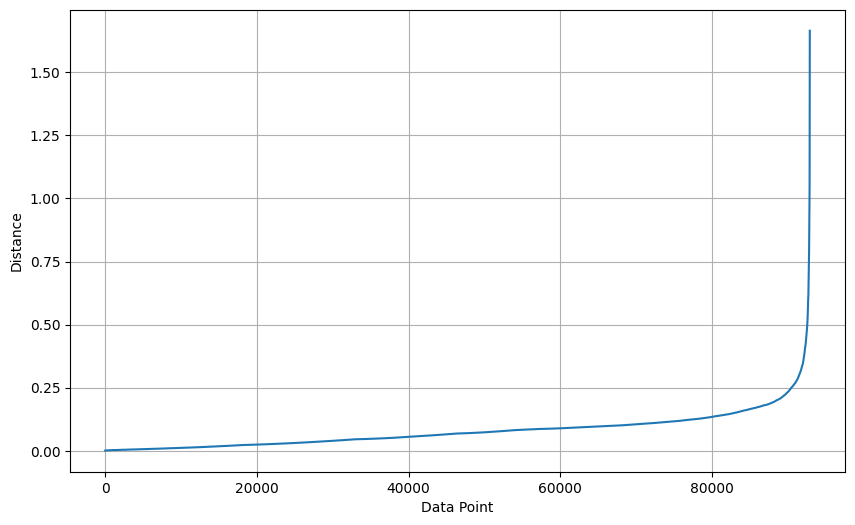

In [65]:
x = normalisasi_df.values
k = 5

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(x)
distances, indices = neighbors_fit.kneighbors(x)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10,6))
plt.plot(k_distances)
plt.xlabel("Data Point")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

In [66]:
dbscan = DBSCAN(eps=0.5, min_samples=8)
labels = dbscan.fit_predict(normalisasi_df.values)

df["Cluster_DBSCAN"] = labels
print(df["Cluster_DBSCAN"].value_counts())

Cluster_DBSCAN
 0    92578
-1      286
 2       15
 1        8
Name: count, dtype: int64


In [67]:
mask = labels != -1
score = silhouette_score(normalisasi_df.values[mask], labels[mask])
print("Silhouette Score: ", score)

Silhouette Score:  0.6360990590086794


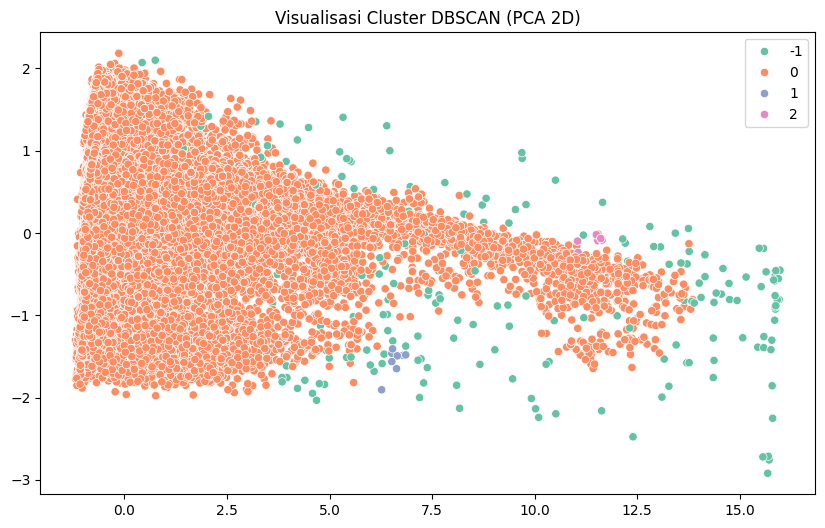

In [68]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(normalisasi_df.values)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette="Set2")
plt.title("Visualisasi Cluster DBSCAN (PCA 2D)")
plt.show()

In [69]:
def klasifikasi_db(x):
  if x == 0:
    return"Baik"
  elif x == 1:
    return"Noise"
  else:
    return "kurang"
df['Klasifikasi_DBSCAN'] = df['Cluster_DBSCAN'].apply(klasifikasi_db)

print(df['Klasifikasi_DBSCAN'].value_counts())

Klasifikasi_DBSCAN
Baik      92578
kurang      301
Noise         8
Name: count, dtype: int64


In [70]:
cluster_summary = df.drop(columns=['tgl','ot', 'strike1', 'dip1',
       'rake1', 'strike2', 'dip2', 'rake2']).groupby('Klasifikasi_DBSCAN').mean(numeric_only=True)

cluster_summary

lat         lon       depth       mag  Cluster_DBSCAN
Klasifikasi_DBSCAN                                                            
Baik               -3.407309  119.166145   47.914008  3.587778        0.000000
Noise              -2.831250  102.895000  342.000000  4.225000        1.000000
kurang             -2.579767  117.611661  378.129568  5.116944       -0.850498

In [71]:
import plotly.express as px

df_pca_db = pd.DataFrame(reduced, columns=['PC1', 'PC2'])
df_pca_db['Klasifikasi_DBSCAN'] = df["Klasifikasi_DBSCAN"].values
df_pca_db['remark'] = df['Klasifikasi_DBSCAN'].values
fig = px.scatter(
    df_pca_db,
    x='PC1', y='PC2',color="Klasifikasi_DBSCAN", hover_name='remark',
    title="persebaran data berdasarkan klasifikasi (DBSCAN)", width= 1500, height= 900)

fig.show()